# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

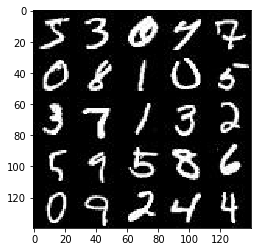

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

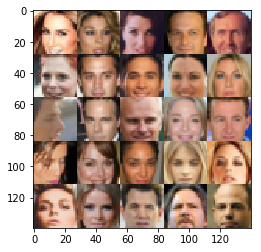

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [61]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    training = True
    #print(images.get_shape())
    with tf.variable_scope('discriminator', reuse=reuse):
        # input: 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 7x7x128
        
#         x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=training)
#         x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 4x4x256
        
#         flat = tf.reshape(x3, (-1, 4*4*256))
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #print(z.get_shape())
    # https://discussions.udacity.com/t/generator-output-shape/247548/4
    reuse = not is_train
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        # input z: 100
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.get_shape())
        # 28x28x5
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # def generator(z, out_channel_dim, is_train=True)
    # def discriminator(images, reuse=False)
    is_train = True
    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    # MNIST: (60000, 28, 28, 1)
    # CelebA: (202599, 28, 28, 3)
    input_real, input_z, learning_rate_p = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
                # Optimize the generator multiple times to learn quickly
                # https://discussions.udacity.com/t/why-does-multiple-iterations-of-generator-model-optimization-per-batch-work-better/248392
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
              
                
                # print losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, 
                                                input_z: batch_z, 
                                                learning_rate_p: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z,
                                                learning_rate_p: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # print the generator output every 100 batches
                if steps % show_every == 0:
                    # def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
        #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.7753 Generator Loss: 0.0070
Epoch 1/2... Discriminator Loss: 4.2957 Generator Loss: 0.0264
Epoch 1/2... Discriminator Loss: 3.4545 Generator Loss: 0.1065
Epoch 1/2... Discriminator Loss: 3.0530 Generator Loss: 0.1835
Epoch 1/2... Discriminator Loss: 2.5373 Generator Loss: 0.3354
Epoch 1/2... Discriminator Loss: 2.6273 Generator Loss: 0.2621
Epoch 1/2... Discriminator Loss: 2.5167 Generator Loss: 0.2374
Epoch 1/2... Discriminator Loss: 2.1144 Generator Loss: 0.3502
Epoch 1/2... Discriminator Loss: 2.2053 Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 1.9580 Generator Loss: 0.5104


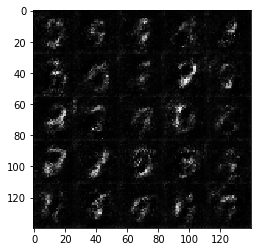

Epoch 1/2... Discriminator Loss: 1.9439 Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.9961 Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.8650 Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 1.8515 Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.8058 Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.7474 Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.6873 Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 1.7745 Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 1.6540 Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.6205 Generator Loss: 0.5988


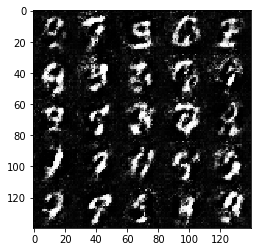

Epoch 1/2... Discriminator Loss: 1.6473 Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.6204 Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.6850 Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.6292 Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.5732 Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.6145 Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.5366 Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.5578 Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.5356 Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 1.5254 Generator Loss: 0.5952


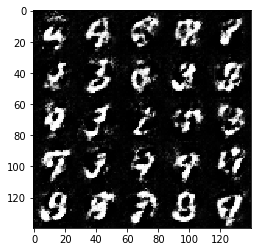

Epoch 1/2... Discriminator Loss: 1.5819 Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 1.5170 Generator Loss: 0.5981
Epoch 1/2... Discriminator Loss: 1.5378 Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.5581 Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.5291 Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.5159 Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.5222 Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.5062 Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.5413 Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.5361 Generator Loss: 0.5983


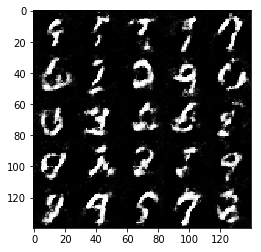

Epoch 1/2... Discriminator Loss: 1.5566 Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.5451 Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.5496 Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 1.5197 Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.5503 Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.5459 Generator Loss: 0.5624
Epoch 2/2... Discriminator Loss: 1.5562 Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 1.5439 Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.5514 Generator Loss: 0.5676
Epoch 2/2... Discriminator Loss: 1.5582 Generator Loss: 0.6506


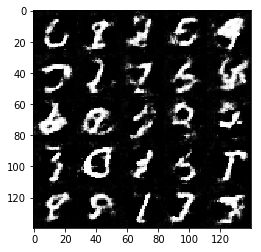

Epoch 2/2... Discriminator Loss: 1.5159 Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.5325 Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.4992 Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.5277 Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.5521 Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 1.4752 Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.5476 Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.5193 Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.5424 Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 1.5238 Generator Loss: 0.5891


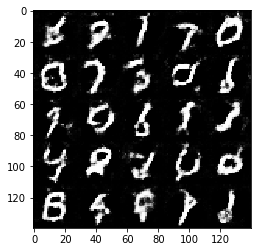

Epoch 2/2... Discriminator Loss: 1.5217 Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 1.4871 Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.5409 Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 1.5383 Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 1.5024 Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.5317 Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.5200 Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.4817 Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.5154 Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.5396 Generator Loss: 0.5905


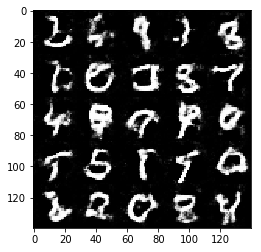

Epoch 2/2... Discriminator Loss: 1.5469 Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.4871 Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.5222 Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.5273 Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.4788 Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.5170 Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.4917 Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.5403 Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 1.5329 Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.5011 Generator Loss: 0.6425


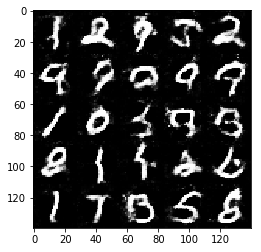

Epoch 2/2... Discriminator Loss: 1.5042 Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.5267 Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.4913 Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.4928 Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.5009 Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.4831 Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.5051 Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.4481 Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.5015 Generator Loss: 0.5911
Epoch 2/2... Discriminator Loss: 1.4748 Generator Loss: 0.7253


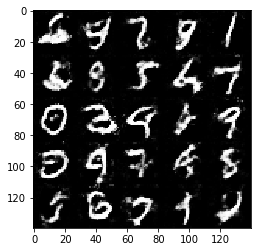

Epoch 2/2... Discriminator Loss: 1.5273 Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 1.4924 Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.4828 Generator Loss: 0.7185


In [67]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#print(mnist_dataset.shape)
#print(mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.5230 Generator Loss: 0.0034
Epoch 1/1... Discriminator Loss: 6.4885 Generator Loss: 0.0036
Epoch 1/1... Discriminator Loss: 4.9165 Generator Loss: 0.0195
Epoch 1/1... Discriminator Loss: 5.0437 Generator Loss: 0.0222
Epoch 1/1... Discriminator Loss: 4.4881 Generator Loss: 0.0633
Epoch 1/1... Discriminator Loss: 1.6824 Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 3.8035 Generator Loss: 0.1089
Epoch 1/1... Discriminator Loss: 3.7091 Generator Loss: 0.0991
Epoch 1/1... Discriminator Loss: 3.7189 Generator Loss: 0.1053
Epoch 1/1... Discriminator Loss: 3.5616 Generator Loss: 0.0850


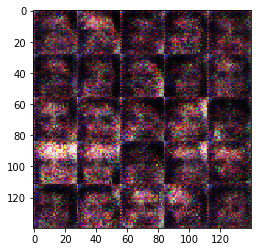

Epoch 1/1... Discriminator Loss: 1.6350 Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 2.4675 Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 2.6402 Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 3.0240 Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 2.8951 Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 2.7437 Generator Loss: 0.3234
Epoch 1/1... Discriminator Loss: 2.5591 Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 2.5241 Generator Loss: 0.3668
Epoch 1/1... Discriminator Loss: 2.2186 Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 2.4443 Generator Loss: 0.3708


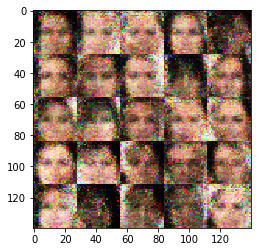

Epoch 1/1... Discriminator Loss: 2.2754 Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 2.1730 Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 2.1863 Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 2.1665 Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 2.0863 Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 2.0018 Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.9737 Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.9016 Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.9008 Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.9198 Generator Loss: 0.5367


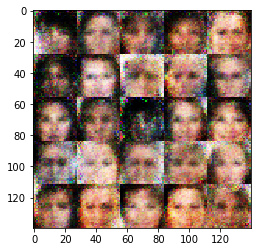

Epoch 1/1... Discriminator Loss: 1.8241 Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.8517 Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.7495 Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.7597 Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.8166 Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.7924 Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.7256 Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.6977 Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.6956 Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.7082 Generator Loss: 0.6032


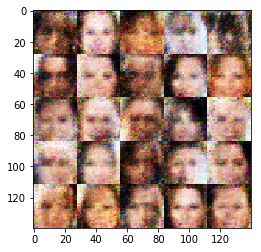

Epoch 1/1... Discriminator Loss: 1.6902 Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.6547 Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.6845 Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.6772 Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.6758 Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.6486 Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.6269 Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.6359 Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.6362 Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.6021 Generator Loss: 0.6697


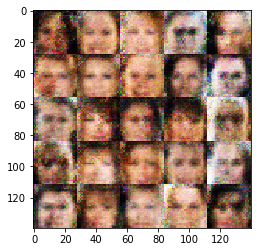

Epoch 1/1... Discriminator Loss: 1.5772 Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.6118 Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.5668 Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.6030 Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5882 Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5693 Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5956 Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5638 Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.5794 Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.5429 Generator Loss: 0.7152


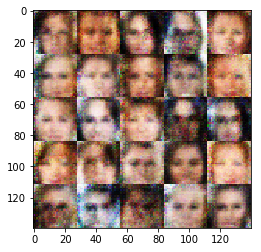

Epoch 1/1... Discriminator Loss: 1.5509 Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5375 Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.5266 Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.5490 Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5523 Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.5380 Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.5674 Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5524 Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5384 Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.5155 Generator Loss: 0.7024


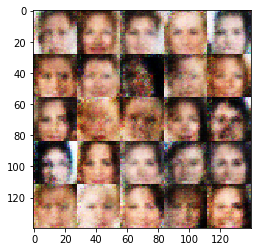

Epoch 1/1... Discriminator Loss: 1.5236 Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.5294 Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.5293 Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.5250 Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.5174 Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.5047 Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.5280 Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.5008 Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5098 Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.5160 Generator Loss: 0.7175


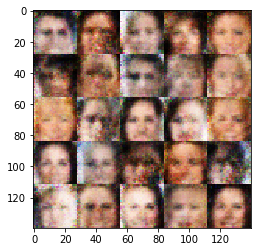

Epoch 1/1... Discriminator Loss: 1.5121 Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5025 Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4966 Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4873 Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.5107 Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4891 Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.5050 Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.5064 Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.5153 Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4820 Generator Loss: 0.7156


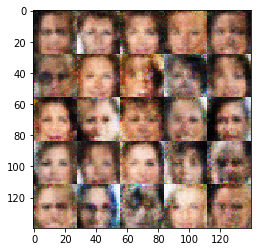

Epoch 1/1... Discriminator Loss: 1.4970 Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4832 Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4957 Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4894 Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4898 Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4883 Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4817 Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4905 Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.5003 Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4994 Generator Loss: 0.7097


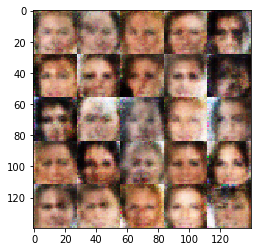

Epoch 1/1... Discriminator Loss: 1.4892 Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4815 Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4788 Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4895 Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4942 Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4840 Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4774 Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4723 Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4654 Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4718 Generator Loss: 0.7289


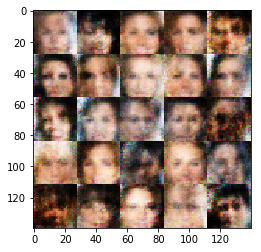

Epoch 1/1... Discriminator Loss: 1.4818 Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4696 Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4642 Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4975 Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4734 Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4674 Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4646 Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4628 Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4556 Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4545 Generator Loss: 0.7444


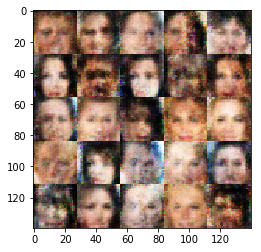

Epoch 1/1... Discriminator Loss: 1.4645 Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4614 Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4577 Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4590 Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4610 Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4585 Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4552 Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4671 Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4556 Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4515 Generator Loss: 0.7545


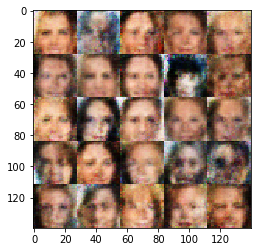

Epoch 1/1... Discriminator Loss: 1.4514 Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4578 Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4471 Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4634 Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4651 Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4431 Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4549 Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4620 Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4456 Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4433 Generator Loss: 0.7374


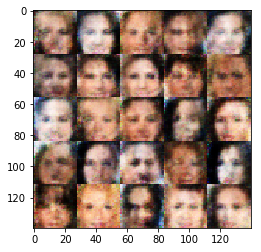

Epoch 1/1... Discriminator Loss: 1.4477 Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4477 Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4484 Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4429 Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4437 Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4467 Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4450 Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4404 Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4432 Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4507 Generator Loss: 0.7202


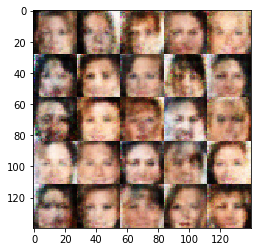

Epoch 1/1... Discriminator Loss: 1.4464 Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4454 Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4385 Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4392 Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4372 Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4379 Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4431 Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4502 Generator Loss: 0.7527


In [69]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
#print(celeba_dataset.shape)
#print(celeba_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.